# 2.4 ADALINEと学習の収束
- ADALINEはパーセプトロンの改良とみなすことができる。
- 学習規則は単位ステップ関数ではなく、線形活性化関数である。
- ADALINEの線形活性化関数$\phi(z)$は総入力の恒等関数であり$\phi(\vec{w}^{T} \vec{x}) = \vec{w}^{T} \vec{x}$となる。
- クラスラベルの予測には量子化器（ステップ関数）が用いられる
- パーセプトロンと比較すると、モデルの誤差の計算と重みの更新に二値ラベルではなく、線形活性化関数からの連続地の出力を資料する。

# 2.5 勾配降下法によるコスト関数の最小化
- 教師あり機械学習のアルゴリズムを構成する主な要素の１つに、学習過程で最適化される目的関数を定義することがあり、その多くは、最小化したいコスト関数である。
- ADALINEの場合ではコスト関数$J$が定義でき、計算結果と本当のクラスラベルとの誤差平方和である。
$$J(\vec{w}) = \frac{1}{2} \sum_{i} (y^{(i)}-\phi(z^{(i)}))^{2}$$

- 連続地の線形活性化関数の主な利点は、コスト関数が微分可能である点である。
- もうひとつの特徴は凸関数であることであり、そのため、勾配降下法を利用することができる。
- 勾配降下法の原理は、コストが最小値に達するまで坂を下るというものである。イテレーションのたびに進む距離は勾配の傾きと、学習率によって決まる。
$$\vec{w} := \vec{w} + \Delta \vec{w}$$
$$\Delta \vec{w} = -\eta \nabla J(\vec{w})$$

- コスト関数の勾配を計算するには、重み$w_{j}$毎にコスト関数の辺微分係数を計算する必要がある。
$$\frac{\partial J}{\partial w_{j}} = -\sum_{i} (y^{(i)} - \phi(z^{(i)}))x^{(i)}_{j}$$
$$\Delta w_{j} = -\eta \nabla J(\vec{w}) = \eta \sum_{i} (y^{(i)} - \phi(z^{(i)}))x^{(i)}_{j}$$

- 重みの更新はトレーニングデータセットのすべてのサンプルに基づいて計算される。

# 2.5.1 ADALINEを実装する

In [1]:
import numpy as np

class AdalineGD(object):
    '''Adaptive Linear Neuron分類器
    
    パラメータ
    ---------
    eta:float
        学習率（0.0〜1.0）
    n_iter:int
        トレーニングデータのトレーニング回数
    
    属性
    ---------
    w_:一次元配列
        適合後の重み
    errors_:リスト
        各エポックでの誤分類数
    
    '''
    def __init__(self,eta=0.01,n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self,X,y):
        '''トレーニングデータに適合させる
        
        パラメータ
        ---------
        X:{配列のようなデータ構造},shape = [n_samples,n_features]
            トレーニングデータ
            n_samplesはサンプルの個数、n_featuresは特徴量の個数
        y:配列のようなデータ構造、shape = [n_samples]
            目的変数
        
        戻り値
        ----------
        self:object

        '''
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter): #トレーニング回数分トレーニングデータを反復
            # 活性化関数の出力の計算
            output = self.net_input(X)
            #誤差の計算
            errors = (y - output)
            #重みwの更新
            self.w_[1:] += self.eta * X.T.dot(errors) #特徴行列と誤差ベクトルとの行列ベクトル積
            #重みw0の更新
            self.w_[0] += self.eta * errors.sum()
            #コスト関数の計算
            cost = (errors**2).sum() / 2.0
            #コストの収納
            self.cost_.append(cost)
        
        return self
    
    def net_input(self,X):
        '''総入力を計算'''
        return np.dot(X,self.w_[1:]) + self.w_[0]
    
    def activation(self,X):
        '''線形活性化関数の出力を計算'''
        return self.net_input(X)
    
    def predict(self,X):
        '''1ステップ後のクラスラベルを返す'''
        return np.where(self.activation(X)>=0.0,1,-1)

- 収束に適した最適な学習率ηを見つけるためには、たいてい、ある程度の実験が必要となる。

In [2]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',header=None)

import matplotlib.pyplot as plt
%matplotlib inline
#1-100行目の目的変数の抽出
y = df.iloc[0:100,4].values

#Iris-setosaを-1,Irsi-virginicaを1に変換
y = np.where(y == 'Iris-setosa',-1,1)

#説明変数の抽出
X = df.iloc[:100,[0,2]].values

/home/kyohei/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


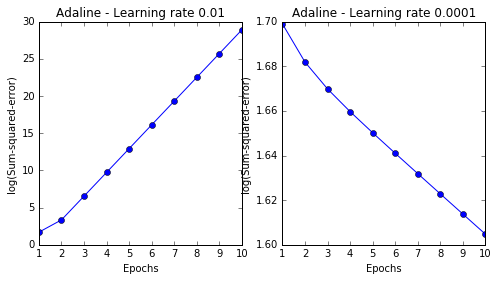

In [3]:
#描画領域を１行２列に分割
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
#勾配降下法によるADALINEの学習
ada1 = AdalineGD(n_iter=10,eta=0.01).fit(X,y)
#エポック数とコストの関係を表す折れ線グラフのプロット（縦軸常用対数）
ax[0].plot(range(1,len(ada1.cost_)+1),np.log10(ada1.cost_),marker='o')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10,eta=0.0001).fit(X,y)
#エポック数とコストの関係を表す折れ線グラフのプロット（縦軸常用対数）
ax[1].plot(range(1,len(ada2.cost_)+1),np.log10(ada2.cost_),marker='o')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

- 左の図は学習率が大きすぎて、大局的最小値を超えてしまっている。
- 右の図はコストが減少しているが、学習率が小さすぎるため、アルゴリズムを収束させるために相当なエポック数が必要となる。

- 機械学習のさまざまなアルゴリズムは、最適なパフォーマンスを実現するため何らかの特徴量のスケーリング必要とする。
- 標準化というスケーリング手法をここでは用いる。
$$x^{'}_{j} = \frac{x_{j}-\mu_{j}}{\sigma_{j}}$$

In [4]:
#データのコピー(別のオブジェクトを作成)
X_std = np.copy(X)

X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

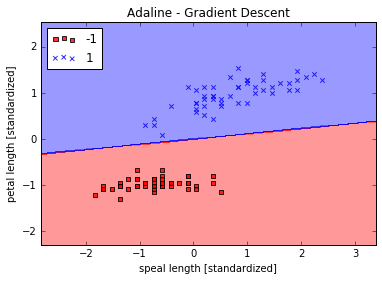

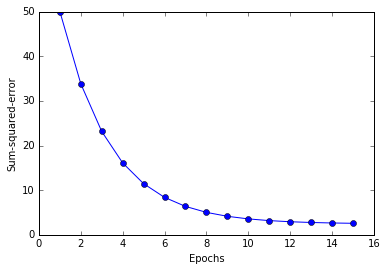

In [7]:
#再び学習率0.01で計算
ada = AdalineGD(n_iter=15,eta=0.01)
ada.fit(X_std,y)
plot_decision_regions(X_std,y,classifier=ada)

plt.title('Adaline - Gradient Descent')

plt.xlabel('speal length [standardized]')
plt.ylabel('petal length [standardized]')

plt.legend(loc='upper left')

plt.show()

#エポック数とコストの関係を表す折れ線グラフのプロット
plt.plot(range(1,len(ada.cost_)+1),ada.cost_,marker='o')

plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.show()

- 標準化された特徴量を学習率η=0.01でトレーニングしたあと、ADALINEは収束する振る舞いを見せた。

In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X,y,classifier,resolution=0.02):
    
    #マーカーとカラーマップの準備
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #決定領域のプロット
    x1_min ,x1_max = X[:,0].min() - 1,X[:,0].max() + 1
    x2_min ,x2_max = X[:,1].min() - 1,X[:,1].max() + 1
    #グリッドポイントの生成
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                          np.arange(x2_min,x2_max,resolution))
    #各特徴量を１次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    #予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    #　グリッドポイントの等高線のプロット
    plt.contourf(xx1,xx2,Z,alpha=0.4,cmap=cmap)
    #軸の範囲の設定
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    #クラスごとにサンプルをプロット
    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl,0],y=X[y == cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl)

# 2.6 大規模な機会学習と確率的勾配降下法
- バッチ勾配降下法のアルゴリズムの代わりによく用いられる。逐次的勾配降下法、オンライン勾配降下法などと呼ばれることもある。
- トレーニングサンプルごとに段階的に重みを更新する。
$$\Delta \vec{w} = \eta(y^{(i)}-\phi(z^{(i)})) \vec{x}^{(i)}$$

- 重みの更新頻度が高いことから高速に収束する。
- 誤差局面のノイズが多いため、浅い極小値を簡単に抜け出せる。
- 確率的勾配降下法を使って正確な結果を得るには、データをランダムな順序に並び替えることが重要

In [10]:
from numpy.random import seed

class AdalineSGD(object):
    '''Adaptive Linear Neuron分類器
    
    パラメータ
    -----------
    eta:float
        学習率（0.0よりおおきく1.0位家の値）
    n_iter:int
        トレーニングデータのトレーニング回数
        
    属性
    -----------
    w_:１次元配列
        適合後の重み
    errors_:リスト
        各エポックでの誤分類数
    shuffle:bool(デフォルト:true)
        循環を回避するために各エポックでトレーニングデータをシャッフル
    random_state:int(デフォルト:None)
        シャッフルに使用するrandom_stateを設定し、初期化
        
    '''
    def __init__(self,eta=0.01,n_iter=10,shuffle=True,random_state=None):
        #学習率の初期化
        self.eta = eta
        #トレーニング回数の初期化
        self.n_iter = n_iter
        #重みの初期化フラグはFalseに設定
        self.w_initialized = False
        #各エポックでトレーニングデータをシャッフルすかどうかのフラグを初期化
        self.shuffle = shuffle
        #引数random_stateが指定された場合は乱数種を設定
        if random_state:
            seed(random_state)
        
    def fit(self,X,y):
        '''トレーニングデータに適合させる
        
        パラメータ
        ----------
        X:{配列のようなデータ構造},shape = [n_samples,n_features]
            トレーニングデータ
            n_samplesはサンプルの個数、n_featuresは特徴量の個数
        y:配列のようなデータ構造,shape = [n_samples]
            目的変数
        
        戻り値
        ----------
        self:object
        
        '''
        #重みベクトルの生成
        self._initialize_weights(X.shape[1])
        #コストを格納するリストの作成
        self.cost_ = []
        #トレーニング回数分トレーニングデータをシャッフル
        for i in range(self.n_iter):
            #指定された場合はトレーニングデータをシャッフル
            if self.shuffle:
                X,y = self._shuffle(X,y)
            #各サンプルのコストを格納するリストの生成
            cost = []
            #各サンプルに対する計算
            for xi,target in zip(X,y):
                #特徴量xiと目的変数yを用いた重みの更新とコストの計算
                cost.append(self._update_weights(xi,target))
            #サンプルの平均コストの計算
            avg_cost = sum(cost)/float(len(y))
            #平均コストを格納
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self,X,y):
        '''重みを最初期化することなくトレーニングデータを適合させる'''
        #初期化されていない場合は初期化を実行
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        #目的yの要素数が2以上の場合は各サンプルの特徴量xiと目的変数targetで重み更新
        if y.ravel().shape[0] > 1:
            self._update_weights(xi,target)
        #目的変数yの要素数が1の場合は各サンプルの全体の特徴量Xと目的変数yで重みを更新
        else:
            self._update_weights(X,y)
        return self
    
    def _shuffle(self,X,y):
        '''トレーニングデータをシャッフル'''
        r = np.random.permutation(len(y))
        return X[r],y[r]
    
    def _initialize_weights(self,m):
        '''重みを0に初期化'''
        self.w_ = np.zeros(1+m)
        self.w_initialized = True
        
    def _update_weights(self,xi,target):
        '''ADALINEの学習規則を用いて重みを更新'''
        #活性化関数の出力の計算
        output = self.net_input(xi)
        #誤差の計算
        error = (target - output)
        #重みwjの更新
        self.w_[1:] += self.eta * xi.dot(error)
        #重みw0の更新
        self.w_[0] += self.eta * error
        #コストの計算
        cost = 0.5 * error**2
        return cost
    
    def net_input(self,X):
        '''総入力を計算'''
        return np.dot(X,self.w_[1:]) + self.w_[0]
    
    def activation(self,X):
        '''線形活性化関数の出力を計算'''
        return self.net_input(X)
    
    def predict(self,X):
        '''1ステップ後のクラスラベルを返す'''
        return np.where(self.activation(X) >= 0.0,1,-1)


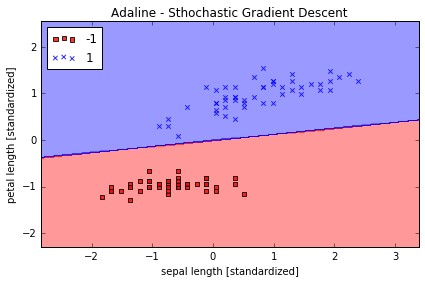

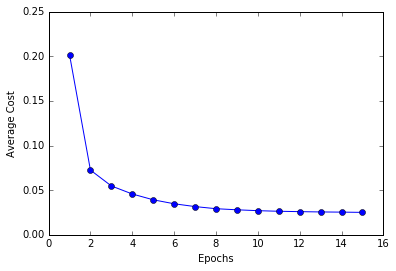

In [11]:
#確率的勾配降下法によるADALINEの学習
ada = AdalineSGD(n_iter=15,eta=0.01,random_state=1)
#モデルへの適合
ada.fit(X_std,y)
#境界領域のプロット
plot_decision_regions(X_std,y,classifier=ada)

plt.title("Adaline - Sthochastic Gradient Descent")
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()
#エポックとコストの折れ線グラフ
plt.plot(range(1,len(ada.cost_)+1),ada.cost_,marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()

- 平均コストがすぐに減少する
- ストリーミングデータをつかって、更新したい場合partial_fitメソッドを呼びだせば良い
- ada.partial_fit(X_std[0,:],y[0])のようになる